Importamos las librerias necesarias para el desarrollo del proyecto

In [1]:
import os
from dotenv import load_dotenv
from PyPDF2 import PdfReader
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.chat_models import ChatOpenAI
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import bert_score

c:\Users\gonzalo.arguedas\Project\TFG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos la API de OpenAI de manera confidencial 

In [2]:
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

if api_key:
    print("API Key cargada correctamente.")
else:
    raise ValueError("No se ha encontrado la API Key en el archivo .env")

# Configurar la clave de API de OpenAI
os.environ["OPENAI_API_KEY"] = api_key

API Key cargada correctamente.


Cargamos el documento sobre el ue vamos a trabajar y posteriormente mostramos el contenido

In [3]:
def extract_text_from_pdf(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
        if not text:
            raise ValueError("El texto extraído del PDF está vacío.")
        return text
    except Exception as e:
        print(f"Error al extraer texto del PDF: {e}")
        return ""


# Ruta al documento PDF
pdf_path = "C:\\Users\\gonzalo.arguedas\\Project\\TFG\\Langchain_evaluation\\construcción del conocimiento.pdf"

# Extraer texto del documento PDF
document_text = extract_text_from_pdf(pdf_path)

# Guardar el texto extraído en un archivo temporal
with open("temp_document.txt", "w", encoding="utf-8") as f:
    f.write(document_text)

# Cargar el texto del documento
document_loader = TextLoader("temp_document.txt")
documents = document_loader.load()

# Mostrar el contenido del documento (primeros 500 caracteres)
print("Contenido del documento:")
print(documents[0].page_content[:500])

Contenido del documento:
Â¿CÃ“MO SE CONSTRUYE EL CONOCIMIENTO?   
 
Juan Delval  
 
* Universidad AutÃ³noma de Madrid.  
El conocimiento sobre la realidad es uno de los factores que mÃ¡s han contribuido al 
Ã©xito adaptativo del hombre como especie animal, ya que permite anticipar lo  que 
va a suceder y a partir de ahÃ­ controlar el curso de las cosas y actuar sobre ellas de 
una manera eficaz para lograr sus objetivos. En definitiva, el conocimiento es el 
arma principal de la que dispone el hombre para controlar la n


A continuación hemos realizado lo siguiente:

- Crear embeddings con OpenAI: Se generan representaciones vectoriales de los documentos utilizando la clase OpenAIEmbeddings, lo que permite convertir texto en vectores numéricos en un espacio de alta dimensión.

- Indexar los documentos utilizando FAISS: Se utiliza la biblioteca FAISS para indexar estos vectores en un almacén de vectores, lo que facilita búsquedas rápidas y eficientes basadas en similitud.

- Configurar el recuperador: Se configura un recuperador a partir del almacén de vectores, permitiendo recuperar documentos relevantes basados en la similitud de sus embeddings con las consultas realizadas.

In [4]:
embeddings = OpenAIEmbeddings()

vector_store = FAISS.from_documents(documents, embeddings)

retriever = vector_store.as_retriever()

c:\Users\gonzalo.arguedas\Project\TFG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


Se crea un modelo de lenguaje utilizando ChatOpenAI con el modelo "gpt-3.5-turbo" y la clave de API proporcionada. A continuación, se configura una cadena de preguntas y respuestas (qa_chain) con la clase RetrievalQA, utilizando el modelo de lenguaje y un recuperador. La cadena de tipo "stuff" gestiona la interacción entre el modelo y el recuperador para responder preguntas basadas en el contenido de los documentos indexados.

In [5]:
llm = ChatOpenAI(api_key=api_key, model_name="gpt-4-turbo")

# Configurar la cadena de preguntas y respuestas
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # Utilizando el tipo de cadena 'stuff'
    retriever=retriever
)

c:\Users\gonzalo.arguedas\Project\TFG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


A continuación se realizan una serie de preguntas para el documento el cual se esta trabjando

In [6]:
preguntas = [
    "¿Cuál es el tema principal del documento?",
    "¿Qué datos específicos se mencionan en el segundo párrafo?",
    "Proporcione un resumen del documento.",
    "¿Hay alguna información contradictoria en el texto?",
    "¿Qué conclusiones se pueden extraer del documento?"
]

In [7]:
respuestas_generadas = []

for pregunta in preguntas:
    respuesta = qa_chain.run({"query": pregunta})
    respuestas_generadas.append(respuesta)
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta generada: {respuesta}\n")

c:\Users\gonzalo.arguedas\Project\TFG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Pregunta: ¿Cuál es el tema principal del documento?
Respuesta generada: El tema principal del documento es la construcción del conocimiento, explorando cómo los seres humanos forman y adquieren nuevos conocimientos a lo largo del tiempo, con un enfoque particular en las teorías y perspectivas de diversos filósofos y psicólogos como Piaget y Vigotski, y abordando la influencia de la educación en este proceso.

Pregunta: ¿Qué datos específicos se mencionan en el segundo párrafo?
Respuesta generada: En el segundo párrafo se mencionan varios datos específicos sobre el conocimiento y su relevancia para el ser humano:

1. El conocimiento ha contribuido significativamente al éxito adaptativo del hombre como especie animal.
2. El conocimiento permite anticipar lo que va a suceder y controlar el curso de las cosas.
3. El conocimiento es esencial para actuar de manera eficaz y alcanzar objetivos.
4. El conocimiento es la principal herramienta del hombre para controlar la naturaleza y sobrevivir.

Este documento describe el proceso de evaluación de la precisión de las respuestas generadas por un modelo de lenguaje utilizando similitud coseno. El objetivo es determinar si las respuestas proporcionadas por el modelo son precisas en relación con el contenido del documento.

**Proceso para Evaluar la Precisión Usando Similitud Coseno**

1. **Generación de Embeddings**:
   - Convertir tanto la respuesta generada por el modelo como el texto relevante del documento en vectores numéricos (embeddings).
   - Los embeddings son representaciones en un espacio vectorial de los textos, donde textos similares están más cercanos entre sí.

2. **Cálculo de la Similitud Coseno**:
   - La similitud coseno se utiliza para medir la similitud entre dos vectores.
   - Fórmula de la similitud coseno:
     $$
     \text{similitud coseno} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
     $$
     donde:
     - **A** y **B** son los vectores de embedding de la respuesta y el texto del documento, respectivamente.
     - **A · B** es el producto punto de los dos vectores.
     - **||A|| ||B||** son las magnitudes (normas) de los vectores.

3. **Determinación de Precisión**:
   - Se define un umbral de similitud.
   - Si la similitud coseno es mayor que este umbral, la respuesta se considera precisa; de lo contrario, se considera una alucinación.


In [8]:
def verificar_respuesta(respuesta, documento, embeddings, umbral_similitud=0.8):
    try:
        respuesta_embedding = embeddings.embed_query(respuesta)
        documento_embedding = embeddings.embed_query(documento)
        similitud = cosine_similarity([respuesta_embedding], [documento_embedding])[0][0]
        if similitud > umbral_similitud:
            return "Precisa", similitud
        else:
            return "Alucinación", similitud
    except Exception as e:
        print(f"Error al verificar la respuesta: {e}")
        return "Error", 0.0


In [9]:
def calcular_bertscore(respuesta, documento):
    try:
        P, R, F1 = bert_score.score([respuesta], [documento], lang="en")
        return P.mean().item(), R.mean().item(), F1.mean().item()
    except Exception as e:
        print(f"Error al calcular BERTScore: {e}")
        return 0.0, 0.0, 0.0

Evaluamos las respuestas generadas por nuestro modelo

In [10]:
resultados = []

for pregunta, respuesta in zip(preguntas, respuestas_generadas):
    precision, similitud = verificar_respuesta(respuesta, documents[0].page_content, embeddings)
    bert_p, bert_r, bert_f1 = calcular_bertscore(respuesta, documents[0].page_content)
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta: {respuesta}")
    print(f"Precisión: {precision}")
    print(f"Similitud: {similitud}")
    print(f"BERTScore P: {bert_p}, R: {bert_r}, F1: {bert_f1}\n")
    resultados.append((pregunta, respuesta, precision, similitud, bert_p, bert_r, bert_f1))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pregunta: ¿Cuál es el tema principal del documento?
Respuesta: El tema principal del documento es la construcción del conocimiento, explorando cómo los seres humanos forman y adquieren nuevos conocimientos a lo largo del tiempo, con un enfoque particular en las teorías y perspectivas de diversos filósofos y psicólogos como Piaget y Vigotski, y abordando la influencia de la educación en este proceso.
Precisión: Precisa
Similitud: 0.8972647247485874
BERTScore P: 0.8299338817596436, R: 0.7602220177650452, F1: 0.7935498952865601



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pregunta: ¿Qué datos específicos se mencionan en el segundo párrafo?
Respuesta: En el segundo párrafo se mencionan varios datos específicos sobre el conocimiento y su relevancia para el ser humano:

1. El conocimiento ha contribuido significativamente al éxito adaptativo del hombre como especie animal.
2. El conocimiento permite anticipar lo que va a suceder y controlar el curso de las cosas.
3. El conocimiento es esencial para actuar de manera eficaz y alcanzar objetivos.
4. El conocimiento es la principal herramienta del hombre para controlar la naturaleza y sobrevivir.

Estos puntos resaltan la importancia del conocimiento en la adaptación y supervivencia de los seres humanos.
Precisión: Precisa
Similitud: 0.8659736255340504
BERTScore P: 0.8820111155509949, R: 0.793769121170044, F1: 0.8355667591094971



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pregunta: Proporcione un resumen del documento.
Respuesta: El documento explora cómo se construye el conocimiento desde una perspectiva histórica y teórica, destacando la importancia de la educación en este proceso. Se mencionan diversas teorías filosóficas y psicológicas, como el empirismo, el innatismo y el constructivismo, para explicar cómo los individuos adquieren y desarrollan conocimientos.

Juan Delval resalta que el conocimiento se forma a través de la interacción social y la transmisión cultural, siendo la educación un medio fundamental para este fin. El texto se enfoca en la teoría de Jean Piaget sobre el constructivismo, la cual sostiene que el conocimiento es el resultado de la interacción activa entre el sujeto y su entorno. Piaget propone que los individuos construyen activamente su conocimiento a través de experiencias y la resolución de discrepancias entre sus ideas y la realidad.

El documento también discute las críticas a la teoría de Piaget y presenta la perspectiv

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pregunta: ¿Hay alguna información contradictoria en el texto?
Respuesta: No se presenta información contradictoria en el texto. Se discuten diferentes teorías y enfoques sobre la adquisición del conocimiento, como el empirismo, el innatismo y el constructivismo, y se describe cómo cada una aborda diferentes aspectos del proceso de formación del conocimiento. Se mencionan críticas y limitaciones de cada teoría, pero siempre dentro de un contexto de discusión y análisis teórico. Además, se hace una distinción clara entre las implicaciones de estas teorías para la educación y el desarrollo del conocimiento en general.
Precisión: Precisa
Similitud: 0.9000439545755159
BERTScore P: 0.8216451406478882, R: 0.7659366130828857, F1: 0.7928134202957153



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pregunta: ¿Qué conclusiones se pueden extraer del documento?
Respuesta: Del documento se pueden extraer las siguientes conclusiones principales:

1. **La importancia del conocimiento**: El conocimiento es fundamental para el éxito adaptativo del ser humano, permitiendo anticipar eventos y controlar el entorno para alcanzar objetivos específicos.

2. **Formación del conocimiento**: Existen diversas teorías filosóficas y psicológicas sobre cómo se adquiere el conocimiento, incluyendo el empirismo, el racionalismo, y las teorías de Kant, así como las concepciones de Piaget y Vigotski.

3. **Constructivismo de Piaget**: Según Piaget, el conocimiento se construye a través de la interacción entre el sujeto y la realidad. El individuo no solo recibe información pasivamente, sino que activamente construye su entendimiento a través de la experiencia y la adaptación.

4. **El papel de la educación**: La educación es vital en la transmisión de conocimientos, no solo en contextos familiares sino t

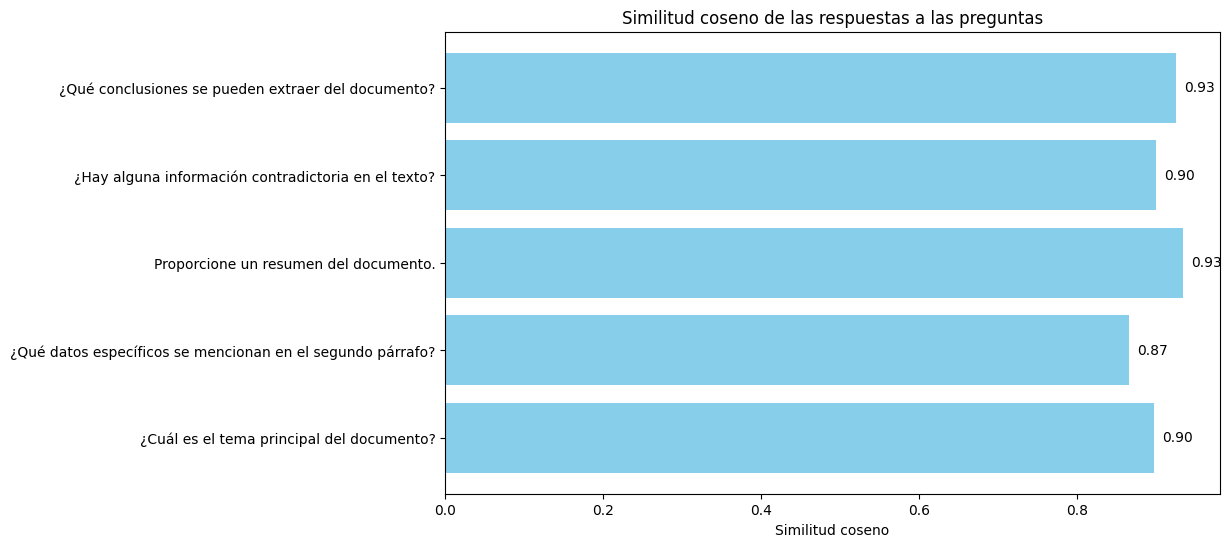

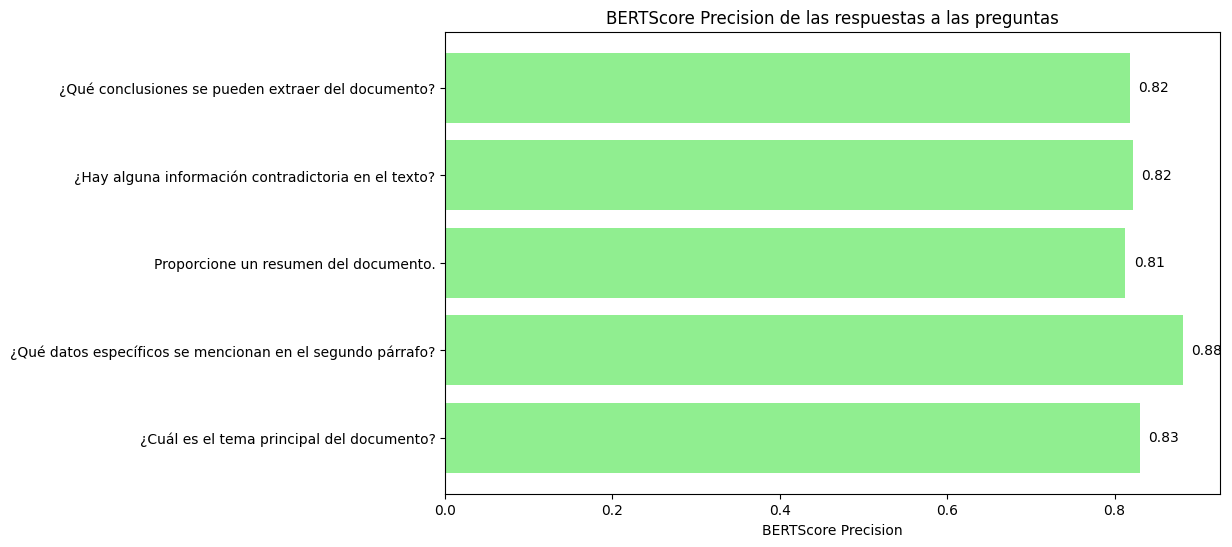

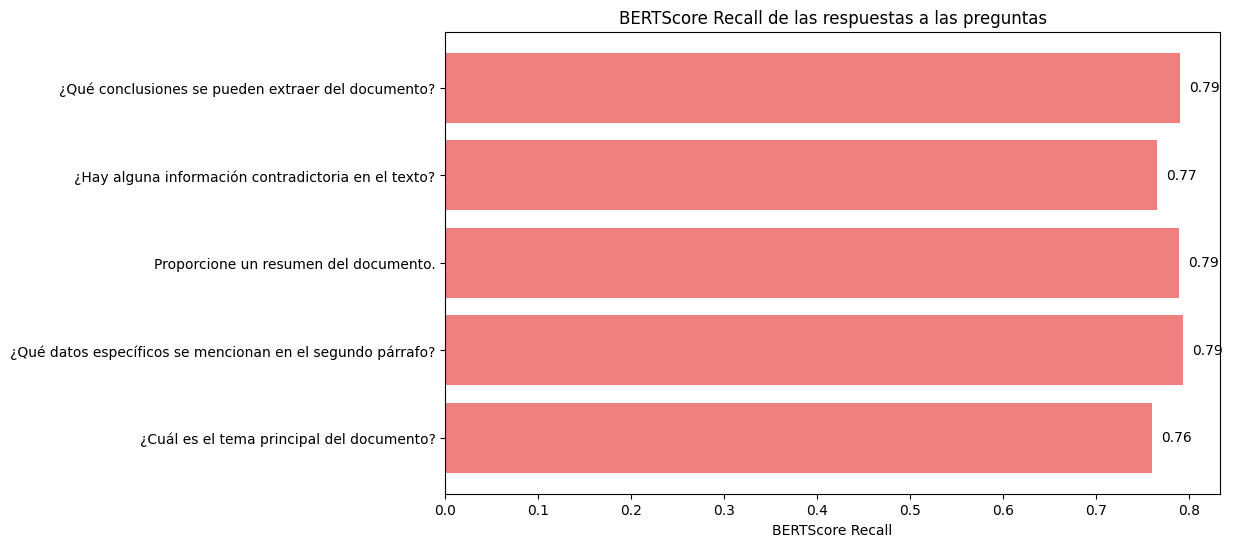

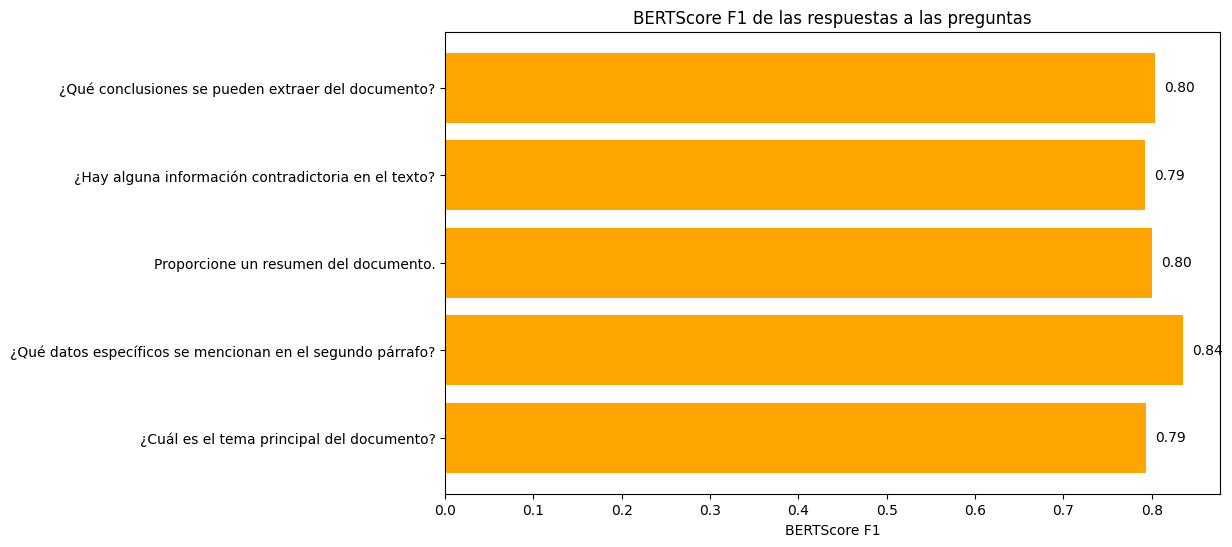

In [11]:
preguntas = [r[0] for r in resultados]
similitudes = [r[3] for r in resultados]
bert_p_scores = [r[4] for r in resultados]
bert_r_scores = [r[5] for r in resultados]
bert_f1_scores = [r[6] for r in resultados]

plt.figure(figsize=(10, 6))
bars = plt.barh(preguntas, similitudes, color='skyblue', label='Similitud coseno')
plt.xlabel('Similitud coseno')
plt.title('Similitud coseno de las respuestas a las preguntas')

# Añadir etiquetas con los valores obtenidos para cada barra
for bar, similitud in zip(bars, similitudes):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{similitud:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

plt.figure(figsize=(10, 6))
bars_bert_p = plt.barh(preguntas, bert_p_scores, color='lightgreen', label='BERTScore Precision')
plt.xlabel('BERTScore Precision')
plt.title('BERTScore Precision de las respuestas a las preguntas')

# Añadir etiquetas con los valores obtenidos para cada barra
for bar, bert_p in zip(bars_bert_p, bert_p_scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{bert_p:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

plt.figure(figsize=(10, 6))
bars_bert_r = plt.barh(preguntas, bert_r_scores, color='lightcoral', label='BERTScore Recall')
plt.xlabel('BERTScore Recall')
plt.title('BERTScore Recall de las respuestas a las preguntas')

# Añadir etiquetas con los valores obtenidos para cada barra
for bar, bert_r in zip(bars_bert_r, bert_r_scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{bert_r:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

plt.figure(figsize=(10, 6))
bars_bert_f1 = plt.barh(preguntas, bert_f1_scores, color='orange', label='BERTScore F1')
plt.xlabel('BERTScore F1')
plt.title('BERTScore F1 de las respuestas a las preguntas')

# Añadir etiquetas con los valores obtenidos para cada barra
for bar, bert_f1 in zip(bars_bert_f1, bert_f1_scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{bert_f1:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()